# 🎧 K-Means Clustering — **Song Mood / Production Typology (Global)**

**Versi v3 — Optimized Mode:**  
- **Evaluasi K pakai Elbow Method + Silhouette** (lebih akurat).  
- **Init K-Means = `k-means++`** dengan multiple runs untuk hasil optimal.  
- **Silhouette dengan sampling** untuk efisiensi pada dataset besar.
- Tetap ada **ekspor cleaned dataset** untuk benchmark di **Orange Data Mining**.


## 0) Setup & Konfigurasi

In [134]:
from pathlib import Path

DATA_DIR = Path("data")  # ganti sesuai lokasi ekstraksi CSV Kaggle
MAX_ROWS = 400_000               # set None bila ingin memuat semua
K_MIN, K_MAX = 2, 15             # range K untuk scanning (diperluas untuk melihat elbow lebih jelas)

print("DATA_DIR:", DATA_DIR.resolve())
print("MAX_ROWS:", MAX_ROWS)
print("K range:", (K_MIN, K_MAX))


DATA_DIR: D:\Kuliah\machine learning\data
MAX_ROWS: 400000
K range: (2, 15)


## 1) Import Library

In [135]:
import warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)


In [136]:
# Install library untuk elbow detection (jalankan jika belum terinstall)
# !pip install kneed

## 2) Load Dataset (Auto-Detect CSV)

In [137]:
ESSENTIAL_COLS = [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature',
    'name','track_name','artists','artist_name','popularity','year','release_date','id','track_id'
]

def find_spotify_csv(base_dir: Path):
    csvs = list(base_dir.rglob("*.csv"))
    print(f"Ditemukan {len(csvs)} file CSV di {base_dir}.")
    best_path, best_score = None, -1
    for p in csvs:
        try:
            df_head = pd.read_csv(p, nrows=2000, low_memory=False)
        except Exception:
            continue
        cols = set(c.lower() for c in df_head.columns)
        score = sum(int(c in cols) for c in [c.lower() for c in ESSENTIAL_COLS])
        if score > best_score:
            best_score, best_path = score, p
    return best_path

csv_path = find_spotify_csv(DATA_DIR)
if csv_path is None:
    raise FileNotFoundError("Tidak menemukan CSV sesuai. Pastikan DATA_DIR benar.")
print("CSV terpilih:", csv_path)


Ditemukan 1 file CSV di data.
CSV terpilih: data\tracks_features.csv


## 3) Baca Data & Seleksi Kolom

In [138]:
FEATURE_COLS_CANDIDATES = [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
]
META_COLS_CANDIDATES = [
    'name','track_name','artists','artist_name','popularity','year','release_date','id','track_id'
]

sample_head = pd.read_csv(csv_path, nrows=5, low_memory=False)
available_cols = set(sample_head.columns)

rename_map = {}
if 'name' in available_cols and 'track_name' not in available_cols:
    rename_map['name'] = 'track_name'
if 'artist_name' in available_cols and 'artists' not in available_cols:
    rename_map['artist_name'] = 'artists'
if 'id' in available_cols and 'track_id' not in available_cols:
    rename_map['id'] = 'track_id'

usecols = [c for c in FEATURE_COLS_CANDIDATES + META_COLS_CANDIDATES if c in available_cols]
dtype_map = {
    'danceability':'float32','energy':'float32','acousticness':'float32',
    'instrumentalness':'float32','liveness':'float32','speechiness':'float32',
    'valence':'float32','tempo':'float32','loudness':'float32',
    'duration_ms':'int32','key':'int8','mode':'int8','time_signature':'int8',
    'popularity':'int16','year':'int16'
}
df = pd.read_csv(csv_path, usecols=usecols, low_memory=False, dtype={k:v for k,v in dtype_map.items() if k in usecols})
df.rename(columns=rename_map, inplace=True)

if MAX_ROWS is not None and len(df) > MAX_ROWS:
    df = df.sample(n=MAX_ROWS, random_state=42).reset_index(drop=True)

print("Shape:", df.shape)
df.head(3)


Shape: (400000, 18)


,track_id,track_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,1aGS6nf2xgv3Xzdob4eOO3,Smokin' Sticky Sticky,['Unk'],0.623,0.736,11,-3.657,0,0.4020,0.0021,0.000,0.0691,0.422,87.987999,380427,4,2006,2006-10-03
1,0fJfoqHIIiET2EcgjOfntG,Holding Back the Years,['Norm Douglas'],0.585,0.639,2,-9.641,0,0.0333,0.3160,0.775,0.0993,0.880,170.082001,266520,4,2008,2008-06-13
2,0V2R2LC8dR7S0REieXRaGt,All Along The Watchtower - Live - 1991,['Indigo Girls'],0.331,0.466,9,-14.287,0,0.0379,0.7090,0.000,0.9390,0.430,90.648003,383773,4,1991,1991-06-04


## 4) Pembersihan Data

In [139]:
has_track_id = 'track_id' in df.columns
has_track_name = 'track_name' in df.columns
has_artists = 'artists' in df.columns

if has_track_id:
    df = df.drop_duplicates(subset=['track_id'])
elif has_track_name and has_artists:
    df = df.drop_duplicates(subset=['track_name','artists'])

FEATS = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
] if c in df.columns]

df = df.dropna(subset=FEATS)

if 'tempo' in df.columns:
    df['tempo'] = df['tempo'].clip(30, 250)
if 'loudness' in df.columns:
    df['loudness'] = df['loudness'].clip(-60, 5)
if 'duration_ms' in df.columns:
    df['duration_ms'] = df['duration_ms'].clip(10_000, 900_000)

print("Setelah cleaning:", df.shape)
df[FEATS].describe().T


Setelah cleaning: (400000, 18)


,count,mean,std,min,25%,50%,75%,max
danceability,400000.0,0.493084,0.189683,0.0,0.356000,0.500000,0.63300,0.994000
energy,400000.0,0.509190,0.294588,0.0,0.252000,0.523000,0.76600,1.000000
acousticness,400000.0,0.447006,0.385003,0.0,0.037700,0.390000,0.86100,0.996000
instrumentalness,400000.0,0.282611,0.376095,0.0,0.000008,0.008060,0.71700,1.000000
liveness,400000.0,0.201845,0.180607,0.0,0.096900,0.125000,0.24600,1.000000
speechiness,400000.0,0.084611,0.116524,0.0,0.035100,0.044500,0.07220,0.966000
valence,400000.0,0.428201,0.270443,0.0,0.191000,0.404000,0.64400,1.000000
tempo,400000.0,117.728302,30.746105,30.0,94.028000,116.713497,137.18325,248.934006
loudness,400000.0,-11.808602,6.975955,-60.0,-15.250000,-9.795000,-6.71800,5.000000
duration_ms,400000.0,245210.710110,126552.897502,10000.0,173987.000000,224203.000000,285827.00000,900000.000000


## 5) Feature Engineering & Scaling

In [140]:
work = df.copy()

if 'duration_ms' in work.columns:
    work['duration_s'] = work['duration_ms'] / 1000.0
    work['log_duration_s'] = np.log1p(work['duration_s'])

if 'key' in work.columns:
    import numpy as np
    two_pi = 2*np.pi
    work['key_sin'] = np.sin(two_pi * (work['key'] % 12) / 12.0)
    work['key_cos'] = np.cos(two_pi * (work['key'] % 12) / 12.0)

num_feats = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','log_duration_s','key_sin','key_cos'
] if c in work.columns]
bin_feats = [c for c in ['mode'] if c in work.columns]
cat_small = [c for c in ['time_signature'] if c in work.columns]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

transformers = []
if num_feats:
    transformers.append(("num", StandardScaler(), num_feats))
if bin_feats:
    transformers.append(("bin", "passthrough", bin_feats))
if cat_small:
    transformers.append(("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_small))

preprocess = ColumnTransformer(transformers=transformers, remainder='drop')
X = preprocess.fit_transform(work)
print("Shape X:", X.shape)


Shape X: (400000, 18)


## 6) Scan K dengan **Elbow Method + Silhouette** (Optimized)

In [ ]:
import time

use_minibatch = (X.shape[0] > 300_000)
ks = list(range(K_MIN, K_MAX+1))
silhouettes = []
inertias = []
fit_times = []

# Sampling untuk silhouette jika data besar (speed optimization)
SILHOUETTE_SAMPLE_SIZE = min(100000, X.shape[0])
sample_indices = np.random.RandomState(42).choice(X.shape[0], SILHOUETTE_SAMPLE_SIZE, replace=False)
X_sample = X[sample_indices]

print(f"Scanning K from {K_MIN} to {K_MAX}...")
print(f"Using {'MiniBatchKMeans' if use_minibatch else 'KMeans'} with k-means++ initialization")
print(f"Silhouette computed on {SILHOUETTE_SAMPLE_SIZE:,} samples (out of {X.shape[0]:,})")
print("-" * 80)

for k in ks:
    print(f"  k={k:2d}...", end=" ")
    start_time = time.time()
    
    if use_minibatch:
        # MiniBatch dengan k-means++ dan multiple inits
        km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096, 
                             init='k-means++', n_init=3, max_iter=1000)
    else:
        # Regular KMeans dengan k-means++ dan 10 inits
        km = KMeans(n_clusters=k, random_state=42, 
                    init='k-means++', n_init=10, max_iter=1000)
    
    labels_tmp = km.fit_predict(X)
    elapsed = time.time() - start_time
    
    # Inertia (distortion score)
    inertias.append(km.inertia_)
    fit_times.append(elapsed)
    
    # Silhouette pada sample untuk speed
    try:
        labels_sample = labels_tmp[sample_indices]
        sil = silhouette_score(X_sample, labels_sample)
        print(f"✓ sil={sil:.4f}, inertia={km.inertia_:.2e}, time={elapsed:.2f}s")
    except Exception as e:
        sil = np.nan
        print(f"✗ inertia={km.inertia_:.2e}, time={elapsed:.2f}s (sil failed)")
    silhouettes.append(sil)

print("-" * 80)
print("Scanning complete!\n")

scan_df = pd.DataFrame({
    "k": ks, 
    "silhouette": silhouettes,
    "inertia": inertias,
    "fit_time": fit_times
})
scan_df


Scanning K from 2 to 15...
Using MiniBatchKMeans with k-means++ initialization
Silhouette computed on 100,000 samples (out of 400,000)
--------------------------------------------------------------------------------
  k= 2... ✓ sil=0.2035, inertia=4.01e+06, time=0.09s
  k= 3... ✓ sil=0.2035, inertia=4.01e+06, time=0.09s
  k= 3... ✓ sil=0.1215, inertia=3.77e+06, time=0.09s
  k= 4... ✓ sil=0.1215, inertia=3.77e+06, time=0.09s
  k= 4... ✓ sil=0.0914, inertia=3.58e+06, time=0.09s
  k= 5... ✓ sil=0.0914, inertia=3.58e+06, time=0.09s
  k= 5... ✓ sil=0.0870, inertia=3.43e+06, time=0.07s
  k= 6... ✓ sil=0.0870, inertia=3.43e+06, time=0.07s
  k= 6... ✓ sil=0.0880, inertia=3.29e+06, time=0.10s
  k= 7... ✓ sil=0.0880, inertia=3.29e+06, time=0.10s
  k= 7... ✓ sil=0.0995, inertia=3.05e+06, time=0.19s
  k= 8... ✓ sil=0.0995, inertia=3.05e+06, time=0.19s
  k= 8... ✓ sil=0.0984, inertia=2.95e+06, time=0.15s
  k= 9... ✓ sil=0.0984, inertia=2.95e+06, time=0.15s
  k= 9... ✓ sil=0.0841, inertia=2.95e+06, 

,k,silhouette,inertia,fit_time
0,2,0.203550,4.009479e+06,0.088150
1,3,0.121497,3.771732e+06,0.090692
2,4,0.091378,3.577732e+06,0.093836
3,5,0.087032,3.430304e+06,0.066864
4,6,0.088030,3.287675e+06,0.104299
5,7,0.099544,3.045433e+06,0.188755
6,8,0.098386,2.952307e+06,0.154375
7,9,0.084143,2.954407e+06,0.199158
8,10,0.092443,2.803002e+06,0.149184
9,11,0.091868,2.705236e+06,0.169410


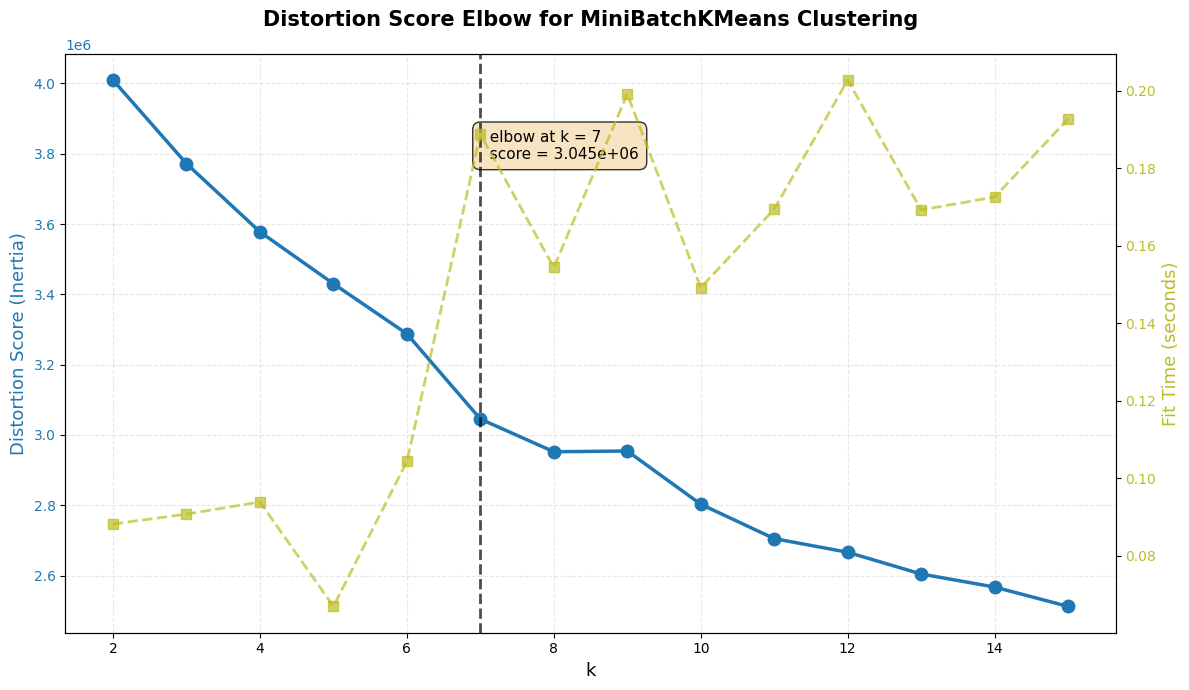


Elbow detected at K = 7
   Inertia at elbow: 3.0454e+06


In [142]:
import numpy as np
from kneed import KneeLocator

# Deteksi elbow menggunakan KneeLocator
try:
    kl = KneeLocator(ks, inertias, curve='convex', direction='decreasing', S=1.0)
    elbow_k = kl.elbow
    elbow_score = inertias[ks.index(elbow_k)] if elbow_k else None
except Exception as e:
    print(f"KneeLocator warning: {e}")
    elbow_k = None
    elbow_score = None

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Axis 1: Distortion Score (Inertia)
color1 = 'tab:blue'
ax1.set_xlabel('k', fontsize=13)
ax1.set_ylabel('Distortion Score (Inertia)', color=color1, fontsize=13)
ax1.plot(ks, inertias, marker='o', color=color1, linewidth=2.5, markersize=9, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')

# Axis 2: Fitting Time
ax2 = ax1.twinx()
color2 = 'tab:olive'
ax2.set_ylabel('Fit Time (seconds)', color=color2, fontsize=13)
ax2.plot(ks, fit_times, marker='s', linestyle='--', color=color2, linewidth=2, markersize=7, alpha=0.7, label='Fit Time')
ax2.tick_params(axis='y', labelcolor=color2)

# Mark elbow point
if elbow_k:
    ax1.axvline(x=elbow_k, color='black', linestyle='--', linewidth=2, alpha=0.7, zorder=10)
    title_text = f'Distortion Score Elbow for {"MiniBatch" if use_minibatch else ""}KMeans Clustering'
    # Posisi text lebih dinamis
    text_y = min(inertias) + (max(inertias) - min(inertias)) * 0.85
    ax1.text(elbow_k, text_y, 
             f'  elbow at k = {elbow_k}\n  score = {elbow_score:.3e}',
             ha='left', fontsize=11, bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8, edgecolor='black'))
else:
    title_text = f'Distortion Score for {"MiniBatch" if use_minibatch else ""}KMeans Clustering'

plt.title(title_text, fontsize=15, fontweight='bold', pad=20)
fig.tight_layout()
plt.show()

print(f"\n{'='*60}")
if elbow_k:
    print(f"Elbow detected at K = {elbow_k}")
    print(f"   Inertia at elbow: {elbow_score:.4e}")
else:
    print("No clear elbow detected - data may not have distinct clusters")
    print("   This is normal for continuous distributions like music features")
print(f"{'='*60}")


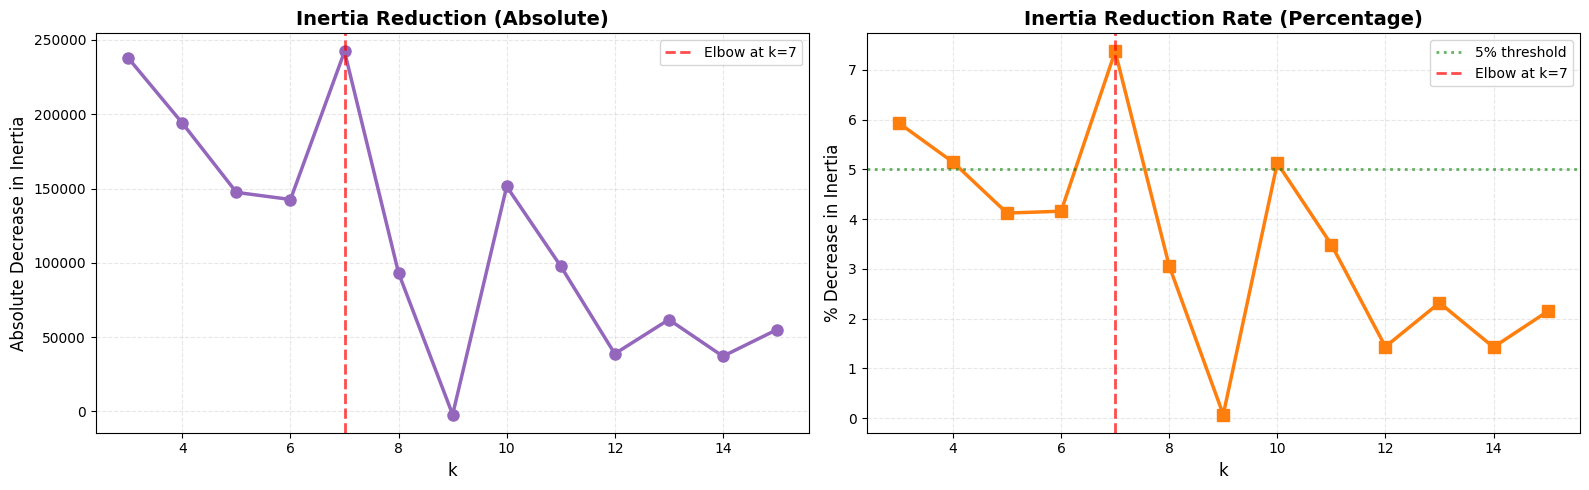

K dimana improvement < 5.0%: K = 5


In [143]:
# Visualisasi Rate of Inertia Reduction (untuk melihat elbow lebih jelas)
inertia_change = np.diff(inertias)
inertia_pct_change = np.abs((inertia_change / inertias[:-1]) * 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Absolute decrease
ax1.plot(ks[1:], -inertia_change, marker='o', linewidth=2.5, markersize=8, color='tab:purple')
ax1.set_xlabel('k', fontsize=12)
ax1.set_ylabel('Absolute Decrease in Inertia', fontsize=12)
ax1.set_title('Inertia Reduction (Absolute)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
if elbow_k and elbow_k in ks[1:]:
    ax1.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Elbow at k={elbow_k}')
    ax1.legend()

# Plot 2: Percentage decrease
ax2.plot(ks[1:], inertia_pct_change, marker='s', linewidth=2.5, markersize=8, color='tab:orange')
ax2.set_xlabel('k', fontsize=12)
ax2.set_ylabel('% Decrease in Inertia', fontsize=12)
ax2.set_title('Inertia Reduction Rate (Percentage)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=5, color='green', linestyle=':', alpha=0.6, linewidth=2, label='5% threshold')
if elbow_k and elbow_k in ks[1:]:
    ax2.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Elbow at k={elbow_k}')
ax2.legend()

plt.tight_layout()
plt.show()

# Cari K dimana improvement < 5%
threshold = 5.0
ks_array = np.array(ks[1:])  # Convert to numpy array
candidates = ks_array[inertia_pct_change < threshold]
if len(candidates) > 0:
    suggested_k_threshold = int(candidates[0])
    print(f"K dimana improvement < {threshold}%: K = {suggested_k_threshold}")
else:
    print(f"Semua K masih memberikan improvement > {threshold}%")

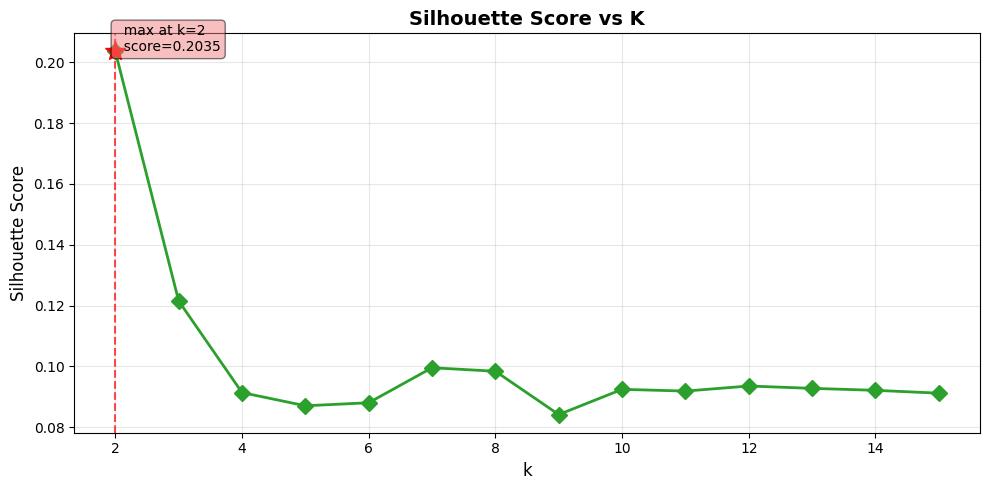

In [144]:
# Visualisasi Silhouette Score (jika tersedia)
if not all(np.isnan(silhouettes)):
    plt.figure(figsize=(10, 5))
    plt.plot(ks, silhouettes, marker='D', color='tab:green', linewidth=2, markersize=8)
    plt.xlabel('k', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Score vs K', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Mark max silhouette
    valid_sil = [(k, s) for k, s in zip(ks, silhouettes) if not np.isnan(s)]
    if valid_sil:
        best_k, best_sil = max(valid_sil, key=lambda x: x[1])
        plt.axvline(x=best_k, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        plt.plot(best_k, best_sil, 'r*', markersize=15)
        plt.text(best_k, best_sil, f'  max at k={best_k}\n  score={best_sil:.4f}',
                ha='left', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("Silhouette scores not available (all NaN)")

## 7) Pilih K Terbaik (Multi-Criteria Decision)

In [145]:
# Multi-Criteria Decision untuk memilih K terbaik
k_candidates = {}

print("="*60)
print("📊 K SELECTION - MULTI-CRITERIA ANALYSIS")
print("="*60)

# Kriteria 1: Dari Elbow Method
if elbow_k:
    k_candidates['elbow_method'] = elbow_k
    print(f"✓ Elbow Method suggests: K = {elbow_k}")
else:
    print("✗ Elbow Method: No clear elbow detected")

# Kriteria 2: Dari Max Silhouette Score
valid_sil = scan_df.dropna(subset=['silhouette'])
if len(valid_sil) > 0:
    k_sil = int(valid_sil.loc[valid_sil['silhouette'].idxmax(), 'k'])
    max_sil_score = valid_sil['silhouette'].max()
    k_candidates['max_silhouette'] = k_sil
    print(f"✓ Max Silhouette suggests: K = {k_sil} (score: {max_sil_score:.4f})")
else:
    print("✗ Silhouette: No valid scores")

# Kriteria 3: Dari Rate of Change (improvement < 5%)
inertia_change = np.diff(inertias)
inertia_pct_change = np.abs((inertia_change / inertias[:-1]) * 100)
threshold = 5.0
ks_array = np.array(ks[1:])  # Convert to numpy array
candidates_threshold = ks_array[inertia_pct_change < threshold]
if len(candidates_threshold) > 0:
    k_threshold = int(candidates_threshold[0])
    k_candidates['rate_threshold'] = k_threshold
    print(f"✓ Rate Threshold (<{threshold}%) suggests: K = {k_threshold}")
else:
    print(f"✗ Rate Threshold: All K still improving >{threshold}%")

print("-"*60)

# Strategi Pemilihan: Prioritas
if k_candidates:
    print("\nDECISION STRATEGY:")
    
    # Prioritas 1: Elbow (paling reliable untuk K-Means)
    if 'elbow_method' in k_candidates:
        K_BEST = k_candidates['elbow_method']
        print(f"   Priority 1: Using ELBOW METHOD → K = {K_BEST}")
    
    # Prioritas 2: Jika Elbow dan Silhouette agree (±1)
    elif 'max_silhouette' in k_candidates and 'elbow_method' in k_candidates:
        if abs(k_candidates['max_silhouette'] - k_candidates['elbow_method']) <= 1:
            K_BEST = k_candidates['elbow_method']
            print(f"   Priority 2: Elbow & Silhouette agree → K = {K_BEST}")
    
    # Prioritas 3: Max Silhouette
    elif 'max_silhouette' in k_candidates:
        K_BEST = k_candidates['max_silhouette']
        print(f"   Priority 3: Using MAX SILHOUETTE → K = {K_BEST}")
    
    # Fallback: Rate threshold
    else:
        K_BEST = k_candidates.get('rate_threshold', int((K_MIN + K_MAX) // 2))
        print(f"   Fallback: Using rate threshold → K = {K_BEST}")
else:
    # Default ke middle
    K_BEST = int((K_MIN + K_MAX) // 2)
    print(f"No clear criteria met, using middle value: K = {K_BEST}")

print("="*60)
print(f"FINAL SELECTION: K = {K_BEST}")
print("="*60)


📊 K SELECTION - MULTI-CRITERIA ANALYSIS
✓ Elbow Method suggests: K = 7
✓ Max Silhouette suggests: K = 2 (score: 0.2035)
✓ Rate Threshold (<5.0%) suggests: K = 5
------------------------------------------------------------

DECISION STRATEGY:
   Priority 1: Using ELBOW METHOD → K = 7
FINAL SELECTION: K = 7


## 8) Fit Model K-Means Akhir (Optimized Init)

In [146]:
print(f"Training final K-Means model with K={K_BEST}...")

if use_minibatch:
    kmodel = MiniBatchKMeans(n_clusters=K_BEST, random_state=42, batch_size=4096, 
                             init='k-means++', n_init=3, max_iter=1500, verbose=0)
else:
    kmodel = KMeans(n_clusters=K_BEST, random_state=42, 
                    init='k-means++', n_init=10, max_iter=1500, verbose=0)

labels = kmodel.fit_predict(X)
work['cluster'] = labels

print(f"Model trained successfully!")
print(f"   Final Inertia: {kmodel.inertia_:.4e}")
print(f"   Number of iterations: {kmodel.n_iter_}")
print(f"\nCluster Distribution:")
print(work['cluster'].value_counts().sort_index())


Training final K-Means model with K=7...
Model trained successfully!
   Final Inertia: 3.0454e+06
   Number of iterations: 3

Cluster Distribution:
cluster
0    63872
1    77946
2    70293
3    24575
4    72278
5    71156
6    19880
Name: count, dtype: int64
Model trained successfully!
   Final Inertia: 3.0454e+06
   Number of iterations: 3

Cluster Distribution:
cluster
0    63872
1    77946
2    70293
3    24575
4    72278
5    71156
6    19880
Name: count, dtype: int64


## 9) Profilisasi Cluster & Penamaan Typology

In [147]:
profile_cols = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','log_duration_s','mode','time_signature'
] if c in work.columns]

cluster_profile = work.groupby('cluster')[profile_cols].mean().reset_index()

def name_cluster(row):
    e=row.get('energy'); v=row.get('valence'); a=row.get('acousticness')
    i=row.get('instrumentalness'); s=row.get('speechiness'); l=row.get('liveness'); d=row.get('danceability')
    tags=[]
    if i is not None and i>=0.6: tags.append('Instrumental / Ambient')
    if s is not None and s>=0.30: tags.append('Spoken / Rap-like')
    if l is not None and l>=0.30: tags.append('Live / Stage')
    if a is not None and a>=0.6 and (e is not None and e<=0.5): tags.append('Acoustic / Chill')
    if e is not None and e>=0.65 and v is not None and v>=0.6 and (a is not None and a<=0.3): tags.append('Energetic Happy Pop/EDM')
    if e is not None and e>=0.65 and v is not None and v<=0.4: tags.append('Intense / Dark')
    if v is not None and v<=0.30 and (e is not None and e<=0.55): tags.append('Sad / Melancholic')
    if not tags:
        if d is not None and d>=0.6: tags.append('Groovy / Danceable')
        else: tags.append('Mixed Mainstream')
    return ' + '.join(tags)

cluster_profile['typology_name'] = cluster_profile.apply(name_cluster, axis=1)
cluster_profile.sort_values('cluster', inplace=True)
cluster_profile


,cluster,danceability,energy,acousticness,instrumentalness,liveness,speechiness,valence,tempo,loudness,log_duration_s,mode,time_signature,typology_name
0,0,0.556917,0.709800,0.178742,0.211164,0.168892,0.073451,0.530379,125.415047,-7.675521,5.429582,0.550319,3.927010,Mixed Mainstream
1,1,0.556549,0.672891,0.224924,0.211559,0.167728,0.067818,0.515420,124.060913,-8.024274,5.418726,0.784094,3.917212,Mixed Mainstream
2,2,0.296422,0.142916,0.877521,0.737472,0.137457,0.046475,0.165605,102.024742,-22.143610,5.498222,0.648528,3.667478,Instrumental / Ambient + Acoustic / Chill + Sa...
3,3,0.454621,0.678823,0.320460,0.188230,0.740294,0.095047,0.448181,121.750999,-9.093982,5.491156,0.692330,3.875646,Live / Stage
4,4,0.554870,0.698190,0.193913,0.206551,0.173557,0.069588,0.533362,124.857285,-7.761133,5.435682,0.631741,3.924057,Mixed Mainstream
5,5,0.466444,0.246166,0.821132,0.151217,0.154075,0.048887,0.356734,112.310440,-14.716457,5.192805,0.728906,3.696470,Acoustic / Chill
6,6,0.652791,0.562502,0.394915,0.045926,0.277357,0.490731,0.535223,112.228584,-11.045324,5.058170,0.602113,3.856388,Spoken / Rap-like


## 10) Contoh Lagu per Cluster

In [148]:
def sample_titles_per_cluster(df_meta: pd.DataFrame, kmodel_labels: np.ndarray, k: int, n_per_cluster=8):
    cols_meta = [c for c in ['track_name','artists','year','popularity'] if c in df_meta.columns]
    out = {}
    for c in range(k):
        idx = np.where(kmodel_labels == c)[0]
        if len(idx)==0:
            out[c]=pd.DataFrame(columns=cols_meta); continue
        take = np.random.RandomState(42).choice(idx, size=min(n_per_cluster, len(idx)), replace=False)
        out[c] = df_meta.iloc[take][cols_meta]
    return out

samples = sample_titles_per_cluster(work, labels, K_BEST, n_per_cluster=8)
list(samples.keys())[:3], samples.get(0, pd.DataFrame()).head(8)


([0, 1, 2],
                   track_name  \
 259714  Take Me To The Cross   
 64284            let me live   
 294945   O Divino Pai Eterno   
 354735          Swedish Song   
 331739                 Intro   
 301471              Funktion   
 386725             I'll Roll   
 109972         Devil Machine   
 
                                                   artists  year  
 259714                                        ['Daywind']  2004  
 64284                                      ['rook&nomie']  2019  
 294945                                   ['Circle Music']  2016  
 354735  ['Lars Danielsson', 'Tigran', 'John Parricelli...  2014  
 331739                                      ['Lil Cuete']  2004  
 301471                                       ['Udi Levy']  2008  
 386725                                   ['Old Dominion']  2019  
 109972                                   ['Silver Talon']  2018  )

## 11) (Opsional) PCA 2D untuk Visualisasi

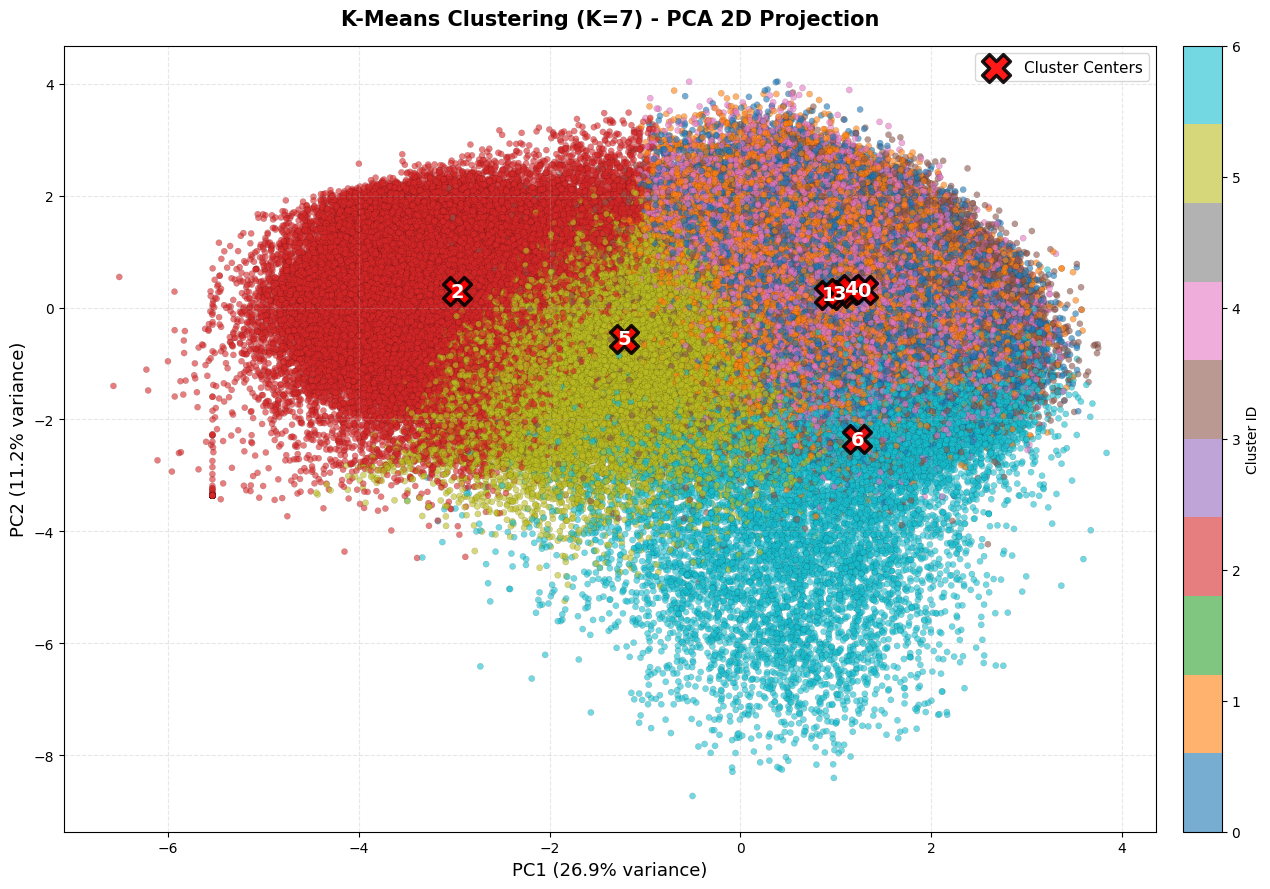

Total variance explained by PC1 + PC2: 38.10%
   (PC1: 26.91%, PC2: 11.19%)


In [149]:
# Enhanced PCA 2D Visualization
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(14, 9))

# Scatter plot dengan colormap
scatter = ax.scatter(X2[:,0], X2[:,1], s=20, alpha=0.6, c=labels, 
                     cmap='tab10', edgecolors='k', linewidths=0.1)

# Plot cluster centers
centroids_2d = pca.transform(kmodel.cluster_centers_)
ax.scatter(centroids_2d[:,0], centroids_2d[:,1], 
          s=400, c='red', marker='X', edgecolors='black', linewidths=2.5, 
          label='Cluster Centers', zorder=10, alpha=0.9)

# Annotate cluster IDs di centroid
for i, (x, y) in enumerate(centroids_2d):
    ax.annotate(f'{i}', (x, y), fontsize=14, fontweight='bold', 
                ha='center', va='center', color='white', zorder=11)

# Styling
plt.colorbar(scatter, ax=ax, label='Cluster ID', pad=0.02)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=13)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=13)
ax.set_title(f'K-Means Clustering (K={K_BEST}) - PCA 2D Projection', 
             fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

total_var = pca.explained_variance_ratio_[:2].sum()
print(f"Total variance explained by PC1 + PC2: {total_var*100:.2f}%")
print(f"   (PC1: {pca.explained_variance_ratio_[0]*100:.2f}%, PC2: {pca.explained_variance_ratio_[1]*100:.2f}%)")


## 12) Ekspor Artefak & Hasil

In [150]:
import joblib
out_dir = Path('./outputs')
(out_dir / 'models').mkdir(parents=True, exist_ok=True)

joblib.dump(preprocess, out_dir / 'models' / 'preprocess.pkl')
joblib.dump(kmodel, out_dir / 'models' / 'kmeans.pkl')

export_cols = [c for c in ['track_name','artists','year','popularity','cluster'] if c in work.columns]
export_df = work[export_cols].copy()
export_df = export_df.merge(cluster_profile[['cluster','typology_name']], on='cluster', how='left')
csv_out = out_dir / 'spotify_clusters.csv'
export_df.to_csv(csv_out, index=False)
print('Disimpan ke:', csv_out.resolve())


Disimpan ke: D:\Kuliah\machine learning\outputs\spotify_clusters.csv


## 13) (Opsional) Rekomendasi Sederhana Berbasis Cluster

In [151]:
from sklearn.metrics import pairwise_distances

def recommend_by_title_partial(title_substr: str, topn=10):
    if 'track_name' not in work.columns:
        raise ValueError("Kolom 'track_name' tidak tersedia.")
    mask = work['track_name'].str.contains(title_substr, case=False, na=False)
    candidates = work[mask]
    if len(candidates)==0:
        print('Tidak menemukan lagu yang cocok.'); return pd.DataFrame()

    anchor = candidates.iloc[0:1]
    idx_anchor = anchor.index[0]
    c_id = int(anchor['cluster'].iloc[0])
    in_same = work[work['cluster']==c_id]
    idxs = in_same.index.values

    D = pairwise_distances(X[idx_anchor:idx_anchor+1], X[idxs], metric='euclidean').ravel()
    order = np.argsort(D)[:topn+1]
    selected = in_same.iloc[order]
    cols = [c for c in ['track_name','artists','year','popularity','cluster'] if c in selected.columns]
    return selected[cols].reset_index(drop=True)


## 14) Ekspor **Dataset Hasil Cleaning** (untuk Orange / Benchmark)

In [152]:
out_dir = Path('./outputs')
out_dir.mkdir(parents=True, exist_ok=True)

meta_cols = [c for c in ['track_name','artists','year','popularity','release_date','track_id'] if c in df.columns]
raw_feats = [c for c in [
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','key','mode','time_signature'
] if c in df.columns]
clean_for_orange = df[meta_cols + raw_feats].copy()
clean_csv = out_dir / 'spotify_cleaned_for_orange.csv'
clean_for_orange.to_csv(clean_csv, index=False)
print('Saved cleaned dataset to:', clean_csv.resolve())

eng_cols = [c for c in [
    'track_name','artists','year','popularity','cluster',
    'danceability','energy','acousticness','instrumentalness','liveness','speechiness','valence',
    'tempo','loudness','duration_ms','log_duration_s','key','key_sin','key_cos','mode','time_signature'
] if c in work.columns]
eng_csv = out_dir / 'spotify_features_engineered.csv'
work[eng_cols].to_csv(eng_csv, index=False)
print('Saved engineered features to:', eng_csv.resolve())


Saved cleaned dataset to: D:\Kuliah\machine learning\outputs\spotify_cleaned_for_orange.csv
Saved engineered features to: D:\Kuliah\machine learning\outputs\spotify_features_engineered.csv
Saved engineered features to: D:\Kuliah\machine learning\outputs\spotify_features_engineered.csv


In [153]:
from scipy.spatial.distance import cdist

print("="*80)
print(" "*25 + "📋 CLUSTERING SUMMARY REPORT")
print("="*80)

# Configuration
print(f"\n🎯 CONFIGURATION:")
print(f"   Dataset: {csv_path.name}")
print(f"   Total samples: {X.shape[0]:,}")
print(f"   Features used: {X.shape[1]}")
print(f"   K range tested: {K_MIN} to {K_MAX}")
print(f"   Algorithm: {'MiniBatchKMeans' if use_minibatch else 'KMeans'}")
print(f"   Initialization: k-means++")
print(f"   Multiple runs: {'n_init=3' if use_minibatch else 'n_init=10'}")

# Model Performance
print(f"\n🏆 BEST MODEL (K={K_BEST}):")
if elbow_k:
    print(f"   Elbow K: {elbow_k}")
valid_sil = scan_df.dropna(subset=['silhouette'])
if len(valid_sil) > 0:
    final_sil_idx = scan_df[scan_df['k'] == K_BEST].index[0]
    final_sil = scan_df.loc[final_sil_idx, 'silhouette']
    if not np.isnan(final_sil):
        print(f"   Silhouette Score: {final_sil:.4f}")
print(f"   Final Inertia: {kmodel.inertia_:.4e}")
print(f"   Iterations: {kmodel.n_iter_}")

# Cluster Statistics
print(f"\n📊 CLUSTER STATISTICS:")
cluster_counts = work['cluster'].value_counts().sort_index()
for i in range(K_BEST):
    count = cluster_counts.get(i, 0)
    pct = (count / len(labels)) * 100
    typology = cluster_profile[cluster_profile['cluster']==i]['typology_name'].iloc[0] if i in cluster_profile['cluster'].values else 'Unknown'
    print(f"   Cluster {i:2d}: {count:6,} songs ({pct:5.1f}%) - {typology}")

# Cluster Quality Metrics
print(f"\n📈 CLUSTER QUALITY METRICS:")
print(f"   Min cluster size: {cluster_counts.min():,}")
print(f"   Max cluster size: {cluster_counts.max():,}")
print(f"   Avg cluster size: {cluster_counts.mean():.0f}")
print(f"   Std cluster size: {cluster_counts.std():.0f}")

balance_score = cluster_counts.std() / cluster_counts.mean()
print(f"   Balance score (std/mean): {balance_score:.4f}")
if balance_score > 1.0:
    print(f"   ⚠️  Warning: Clusters are imbalanced")
else:
    print(f"   ✓  Clusters are relatively balanced")

# Centroid separation
centroids = kmodel.cluster_centers_
centroid_distances = cdist(centroids, centroids, metric='euclidean')
np.fill_diagonal(centroid_distances, np.nan)
avg_separation = np.nanmean(centroid_distances)
print(f"   Avg centroid separation: {avg_separation:.4f}")

# Output files
print(f"\n💾 OUTPUT FILES:")
print(f"   Cluster results: {csv_out}")
print(f"   Cleaned data (Orange): {clean_csv}")
print(f"   Engineered features: {eng_csv}")
print(f"   Models: {out_dir / 'models'}")

print("\n" + "="*80)
print("✅ Analysis complete! Ready for deployment or further analysis.")
print("="*80)

                         📋 CLUSTERING SUMMARY REPORT

🎯 CONFIGURATION:
   Dataset: tracks_features.csv
   Total samples: 400,000
   Features used: 18
   K range tested: 2 to 15
   Algorithm: MiniBatchKMeans
   Initialization: k-means++
   Multiple runs: n_init=3

🏆 BEST MODEL (K=7):
   Elbow K: 7
   Silhouette Score: 0.0995
   Final Inertia: 3.0454e+06
   Iterations: 3

📊 CLUSTER STATISTICS:
   Cluster  0: 63,872 songs ( 16.0%) - Mixed Mainstream
   Cluster  1: 77,946 songs ( 19.5%) - Mixed Mainstream
   Cluster  2: 70,293 songs ( 17.6%) - Instrumental / Ambient + Acoustic / Chill + Sad / Melancholic
   Cluster  3: 24,575 songs (  6.1%) - Live / Stage
   Cluster  4: 72,278 songs ( 18.1%) - Mixed Mainstream
   Cluster  5: 71,156 songs ( 17.8%) - Acoustic / Chill
   Cluster  6: 19,880 songs (  5.0%) - Spoken / Rap-like

📈 CLUSTER QUALITY METRICS:
   Min cluster size: 19,880
   Max cluster size: 77,946
   Avg cluster size: 57143
   Std cluster size: 24240
   Balance score (std/mean): 0.42

## 15) Summary Report & Cluster Validation